In [1]:
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.experiment_history import ExperimentHistory
from scipy import stats
import time
import os
import cv2
from lib.utilities import *

In [2]:
# Make the process for getting electrode / corners coordinates automatic and accurate
# Defined per measurements in https://github.com/john-judge/TSM-to-ZDA/issues/12
# User selection + write to dat files immediately: corners.dat, electrode.dat

dir_base = "C:/Users/jjudge3/Desktop/Data/"
date = '03-07-23'
data_dir = dir_base + date +"/"
camera_program = 4

cre_line_type = None
quick_test = False

slice_target, rec_target, tbs_recording_no, cre_line_type = ExperimentHistory().load(date)

1-1.tif
1-1e.tif
1-1f.tif
1-1fe.tif
1-2e.tif
1-2f.tif
1-3e.tif
1-3f.tif
1-4f.tif
1-5e.tif
1-5f.tif
2-1.tif
2-1e.tif
2-1f.tif
2-1fe.tif
2-2e.tif
2-2fe.tif
2-3e.tif
3-1.tif
3-1e.tif
3-1f.tif
3-1fe.tif
discard
(410, 490)


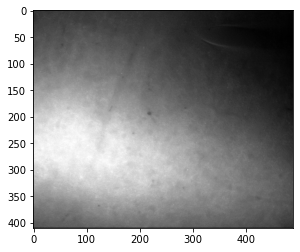

In [7]:
# read in 8-bit single TIF images to array, apply same cropping/binning
image_data = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(2048 / 400) # if want size similar to RLI

TIFLoader(dic_dir, 
          cam_settings, 
          binning, 
          crop=False, 
          flip_horiz=True).load_files(image_data, slice_target=slice_target[0])
try:
    print(list(image_data[slice_target[0]].values())[0]['i'].shape)
except Exception as e:
    print("error", e)

1 1
Number of shapes drawn: 5


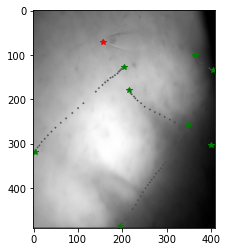

Electrode point: [34, 17]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_1/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_1/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_1/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/1_1/
1 2
Number of shapes drawn: 5


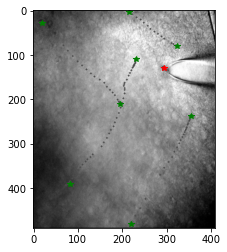

Electrode point: [58, 26]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_2/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_2/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_2/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/1_2/
1 3
Number of shapes drawn: 5


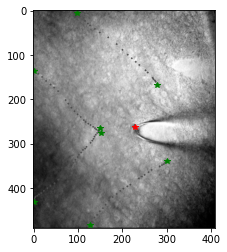

Electrode point: [45, 42]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_3/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_3/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_3/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/1_3/
1 4
Number of shapes drawn: 5


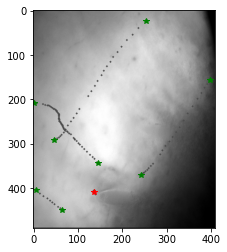

Electrode point: [27, 60]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_4/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_4/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_4/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/1_4/
1 5
Number of shapes drawn: 5


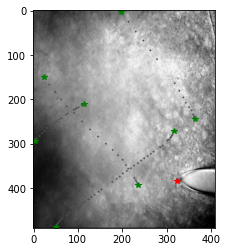

Electrode point: [60, 60]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_5/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_5/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/1_5/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/1_5/
2 1
Number of shapes drawn: 5


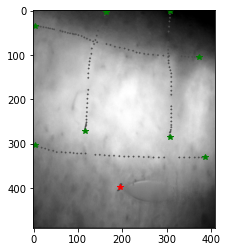

Electrode point: [37, 60]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_1/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_1/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_1/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/2_1/
2 2
Number of shapes drawn: 5


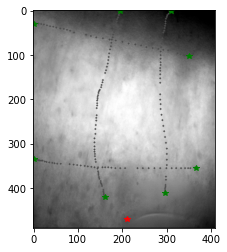

Electrode point: [40, 69]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_2/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_2/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_2/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/2_2/
2 3
Number of shapes drawn: 5


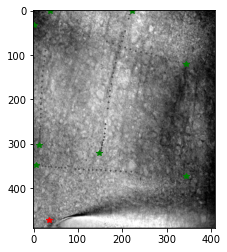

Electrode point: [9, 67]
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_3/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_3/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/03-07-23/2_3/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/03-07-23/2_3/


In [9]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
dic_coordinates = [[8, 6], [80, 12], [2, 69], [76, 74]]
img_aligner = ImageAlign(dic_coordinates)

for slic in image_data:
    for loc in image_data[slic]:
        if slic in slice_target:

            print(slic, loc)

            # DICs
            fluor = None
            if 'f' in image_data[slic][loc]:
                fluor = image_data[slic][loc]['f']
            elif 'fe' in image_data[slic][loc]:
                fluor = image_data[slic][loc]['fe']
            # img = image_data[slic][loc]['i']
            
            dic_electrode = None
            if 'e' in image_data[slic][loc]:
                dic_electrode = image_data[slic][loc]['e']
            else:
                dic_electrode = fluor
            
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            orig_arr_shape = dic_electrode.shape

            # ask user to select site of stim and layer/barrel borders
            try:
                dic_electrode, coordinates = img_aligner.draw_on_image(dic_electrode)
            except Exception as e:
                print("User error in drawing.")
                print(e)
                continue
            dic_electrode = np.array(dic_electrode)

            plt.imshow(dic_electrode, cmap='gray')
            x_el, y_el = coordinates['electrode']
            plt.plot(x_el, y_el, marker="*", color='red')

            for pt in coordinates['layer_axis1'] + coordinates['layer_axis2'] + coordinates['barrel_axis1'] + coordinates['barrel_axis2']:
                x, y = pt
                plt.plot(x, y, marker="*", color='green')
            plt.show()

            dst_dir = data_dir + str(slic) + "_" + str(loc) + "/"
            try:
                os.makedirs(dst_dir)
            except OSError:
                pass
            
            # transform coordinates -- Actual alignment work done here
            coordinates = img_aligner.transform_from_dic_coordinates(coordinates, orig_arr_shape)
            
            # write to file
            electrode_file = dst_dir + "electrode.dat"
            corners_layer_file = dst_dir + "corners_layer.dat"
            corners_barrel_file = dst_dir + "corners_barrel.dat"
            img_aligner.write_shapes_to_files(coordinates,
                                              electrode_file,
                                              corners_layer_file,
                                              corners_barrel_file)
            print("Wrote files to", dst_dir)

